In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import cv2
import os, time, glob, socket
import pandas as pd
import mpl_finance as mpf
from talib import abstract
from datetime import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import talib

In [2]:
df = pd.read_csv("S_P.csv") 
print(df.shape)
df.head()

(6797, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,1994/1/3,466.51001,466.940002,464.359985,465.440002,465.440002,270140000
1,1994/1/4,465.440002,466.890015,464.440002,466.890015,466.890015,326600000
2,1994/1/5,466.890015,467.820007,465.920013,467.549988,467.549988,400030000
3,1994/1/6,467.549988,469,467.019989,467.119995,467.119995,365960000
4,1994/1/7,467.089996,470.26001,467.029999,469.899994,469.899994,324920000


In [3]:
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Adj Close'] = df['Adj Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)

# MA
df['MA10'] = df['Close'].rolling(10).mean()
df['MA30'] = df['Close'].rolling(30).mean()

# K、D
K,D = talib.STOCH(high = np.array(df['High']), 
                low = np.array(df['Low']), 
                 close = np.array(df['Close']),
                 fastk_period=9,
                 slowk_period=3,
                 slowk_matype=0,
                 slowd_period=3,
                 slowd_matype=0)
df['K']=K
df['D']=D

df['year']=pd.to_datetime(df['Date']).dt.to_period('y')
df['Date'] = pd.to_datetime(df['Date'])
df['Date_num'] = df['Date'].apply(mpl_dates.date2num)

# 1-(i)-plot 2019

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


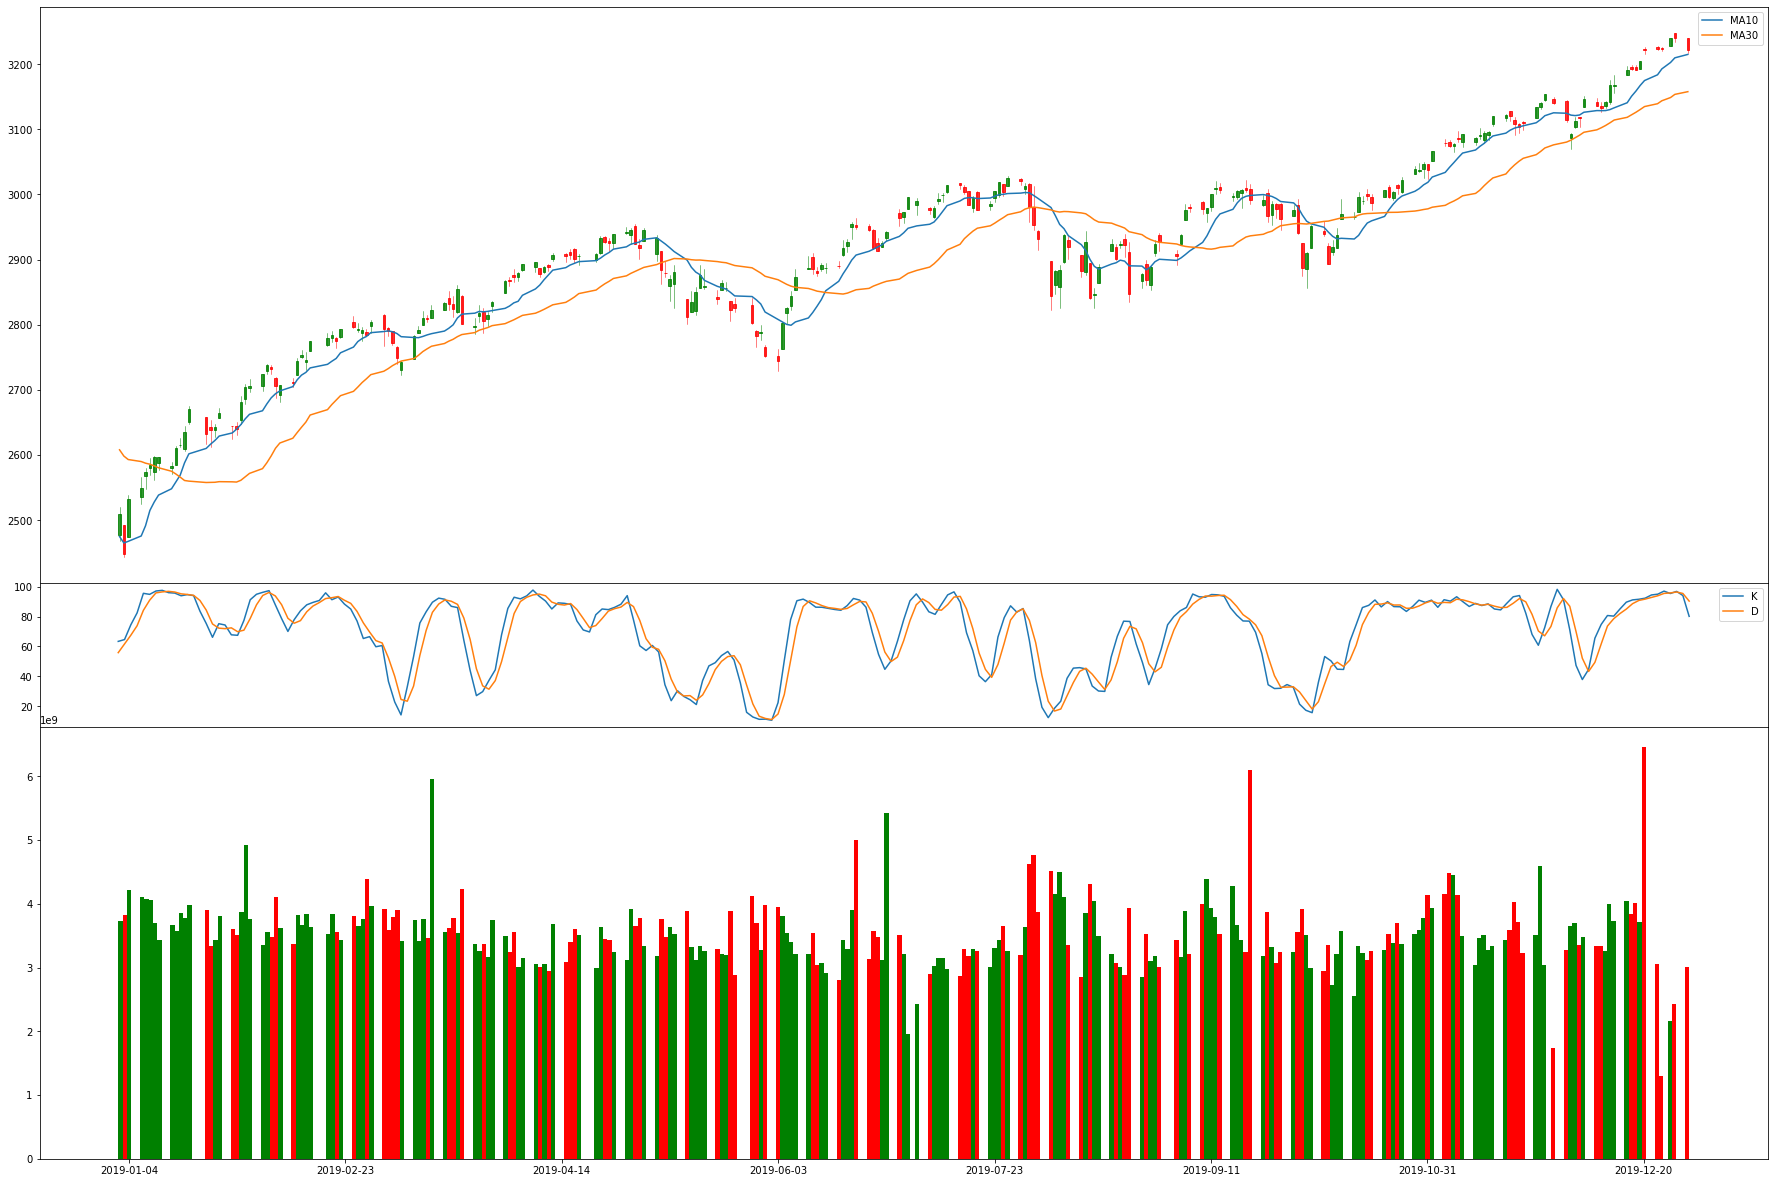

In [4]:
pdata=df[df.year.dt.year == 2019].drop(['year'],axis=1)
# get data from candlesticks for a bar plot
dates = pdata['Date_num']
volume = pdata['Volume']

pos = pdata['Open']-pdata['Close']<0
neg = pdata['Open']-pdata['Close']>0


# Creating Subplots

fig = plt.figure(figsize=(24, 20))
ax = fig.add_axes([0,0.5,1,0.4])
ax2 = fig.add_axes([0,0.4,1,0.1])
ax3 = fig.add_axes([0,0.1,1,0.3])

d=pdata[['Date_num','Open','High','Low','Close']]
candlestick_ohlc(ax,d.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
ax.plot(pdata['Date_num'], pdata['MA10'], label='MA10')
ax.plot(pdata['Date_num'], pdata['MA30'], label='MA30')
ax.legend()

ax2.plot(pdata['K'], label='K')
ax2.plot(pdata['D'], label='D')
ax2.legend()

# make bar plots and color differently depending on up/down for the day
ax3.bar(dates[pos],volume[pos],color='green',width=1,align='center')
ax3.bar(dates[neg],volume[neg],color='red',width=1,align='center')

# Formatting Date
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
ax3.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig('plot.png')
plt.show()

# 1-(ii)

In [5]:
# add weekday

df['weekday'] = df['Date'].dt.dayofweek.astype('string')
day_of_week_columns = pd.get_dummies(df['weekday'])
df=df.merge(day_of_week_columns, left_index=True, right_index=True)
df=df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA10',
       'MA30', 'K', 'D', '0', '1', '2', '3', '4','year']]

In [7]:
# 1994-2017(train) / 2018-2019(val)
train=df[df.year.dt.year <= 2017].drop(['year'],axis=1)
val=df[(df.year.dt.year <= 2019)&(df.year.dt.year > 2017)].drop(['year'],axis=1)
test=df[df.year.dt.year >= 2020].drop(['year'],axis=1)
print(train.shape)
print(val.shape)
print(test.shape)

(6043, 16)
(502, 16)
(252, 16)


In [8]:
# normalized
train_n=train.copy()
train_min=train.iloc[:,1:11].min()
train_max=train.iloc[:,1:11].max()
train_n.iloc[:,1:11]=(train.iloc[:,1:11]-train_min)/(train_max-train_min)

val_n=val.copy()
val_min=val.iloc[:,1:11].min()
val_max=val.iloc[:,1:11].max()
val_n.iloc[:,1:11]=(val.iloc[:,1:11]-val_min)/(val_max-val_min)
#val_n.iloc[:,1:11]=(val.iloc[:,1:11]-train_min)/(train_max-train_min)

test_n=test.copy()
test_min=test.iloc[:,1:11].min()
test_max=test.iloc[:,1:11].max()
test_n.iloc[:,1:11]=(test.iloc[:,1:11]-test_min)/(test_max-test_min)
#test_n.iloc[:,1:11]=(test.iloc[:,1:11]-train_min)/(train_max-train_min)

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


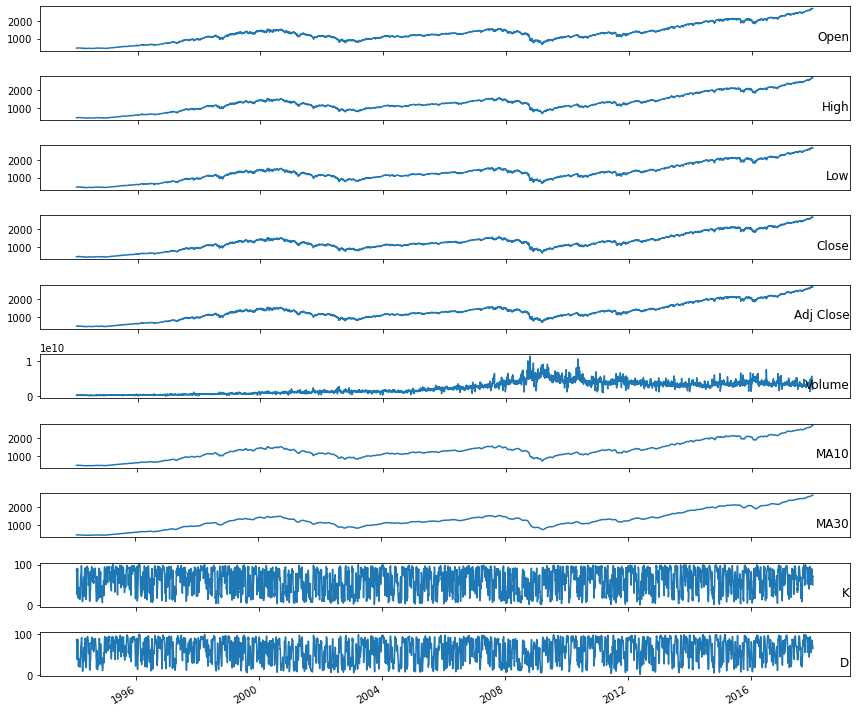

In [9]:
values = train.values
# specify columns to plot
groups = [1, 2, 3, 4,5, 6, 7,8,9,10]
i = 1


fig =plt.figure(figsize=(12,10))
ax = fig.add_axes([0,0,1,1])
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(train['Date'],values[:, group])
    plt.title(train.columns[group], y=0.1, loc='right')
    i += 1
    
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
fig.show()

# 1-(iii)

In [10]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [11]:
#給定過去 30 天的觀察結果，我們需要預測接下來的 1天觀察結果

def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  # n_future ==> no of future observations 
 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [12]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
      
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x.cuda(), h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        #print(out.shape)
        out = out[:, -1, :]
        #print(out)
        #out=out.squeeze()[-1, :]
        #out=out[:, -1]
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
       # out=out.squeeze()[-1, :]
        #print(out.shape)
        return out

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x.cuda(), (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [14]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x.cuda(), h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [15]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [16]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                   # print(yhat)
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        #torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().cpu().numpy())
                values.append(y_test.to(device).detach().cpu().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()       

In [17]:
batch_size =128
input_dimension =n_features = 16
n_past = time_step =30
n_future = 1 

# train
X_train, y_train = split_series(train_n.values,n_past, n_future)
X_train=X_train[29:,:,1:] #drop timestamp
y_train=y_train[29:,:,4:5] # close

X_train=X_train.astype(np.float)
X_train = torch.from_numpy(X_train).float().type(torch.Tensor).cuda()  #torch.Size([6013, 30, 15])

y_train=np.vstack(y_train).astype(np.float)
y_train = torch.from_numpy(y_train).float().type(torch.Tensor).cuda() #torch.Size([6013, 1])

# val
X_val, y_val = split_series(val_n.values,n_past, n_future) 
X_val=X_val[:,:,1:] #drop timestamp
y_val=y_val[:,:,4:5] # close

X_val=X_val.astype(np.float)
X_val = torch.from_numpy(X_val).float().type(torch.Tensor).cuda()

y_val=np.vstack(y_val).astype(np.float)
y_val = torch.from_numpy(y_val).float().type(torch.Tensor).cuda()

# test
X_test, y_test = split_series(test_n.values,n_past, n_future)
X_test=X_test[:,:,1:] #drop timestamp
y_test=y_test[:,:,4:5] # close


X_test=X_test.astype(np.float)
X_test = torch.from_numpy(X_test).float().type(torch.Tensor).cuda()

y_test=np.vstack(y_test).astype(np.float)
y_test = torch.from_numpy(y_test).float().type(torch.Tensor).cuda()

print(X_train.size())
print(y_train.size())

train_t = torch.utils.data.TensorDataset(X_train,y_train)
val_t = torch.utils.data.TensorDataset(X_val,y_val)
test_t = torch.utils.data.TensorDataset(X_test,y_test)

train_loader = DataLoader(train_t, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_t, batch_size=batch_size, shuffle=False)
val_loader_one = DataLoader(val_t, batch_size=1, shuffle=False, drop_last=True)

test_loader = DataLoader(test_t, batch_size=batch_size, shuffle=False)
test_loader_one = DataLoader(test_t, batch_size=1, shuffle=False, drop_last=True)

dataiter = iter(train_loader)
feature, labels = dataiter.next()
print(feature.shape)
print(labels.shape)

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


torch.Size([5984, 30, 15])
torch.Size([5984, 1])
torch.Size([128, 30, 15])
torch.Size([128, 1])


C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecate

In [18]:

input_dim = 15
output_dim = 1
hidden_dim = 64
layer_dim = 3
dropout = 0.2
n_epochs =20
learning_rate = 1e-3
weight_decay = 1e-6

## Simple RNN

In [19]:
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('rnn', model_params).cuda()
print(model)

RNNModel(
  (rnn): RNN(15, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [23]:
from torchviz import make_dot


g=make_dot(model(X_train),params=dict(list(model.named_parameters())))
g.view()
g.render("simple_rnn", format="png")

'simple_rnn.png'

[1/20] Training loss: 0.0225	 Validation loss: 0.1822
[2/20] Training loss: 0.0516	 Validation loss: 0.0889
[3/20] Training loss: 0.0111	 Validation loss: 0.0453
[4/20] Training loss: 0.0123	 Validation loss: 0.0281
[5/20] Training loss: 0.0085	 Validation loss: 0.0256
[6/20] Training loss: 0.0110	 Validation loss: 0.0166
[7/20] Training loss: 0.0148	 Validation loss: 0.0307
[8/20] Training loss: 0.0124	 Validation loss: 0.0240
[9/20] Training loss: 0.0090	 Validation loss: 0.0121
[10/20] Training loss: 0.0085	 Validation loss: 0.0074


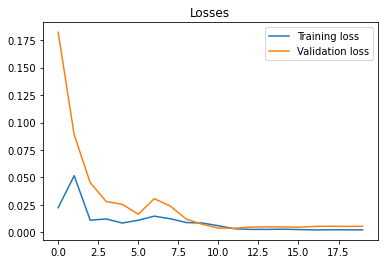

In [534]:
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
opt1 = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)

opt1.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)


opt1.plot_losses()

In [22]:
# plot 2018-2019

In [23]:
# val
# predictions, values = opt.evaluate(val_loader_one, batch_size=1, n_features=input_dim)
# vals = np.concatenate(values, axis=0).ravel()
# preds = np.concatenate(predictions, axis=0).ravel()
# vals_trans=vals*(val_max[3]-val_min[3])+val_min[3]
# preds_trans_64=preds*(val_max[3]-val_min[3])+val_min[3]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


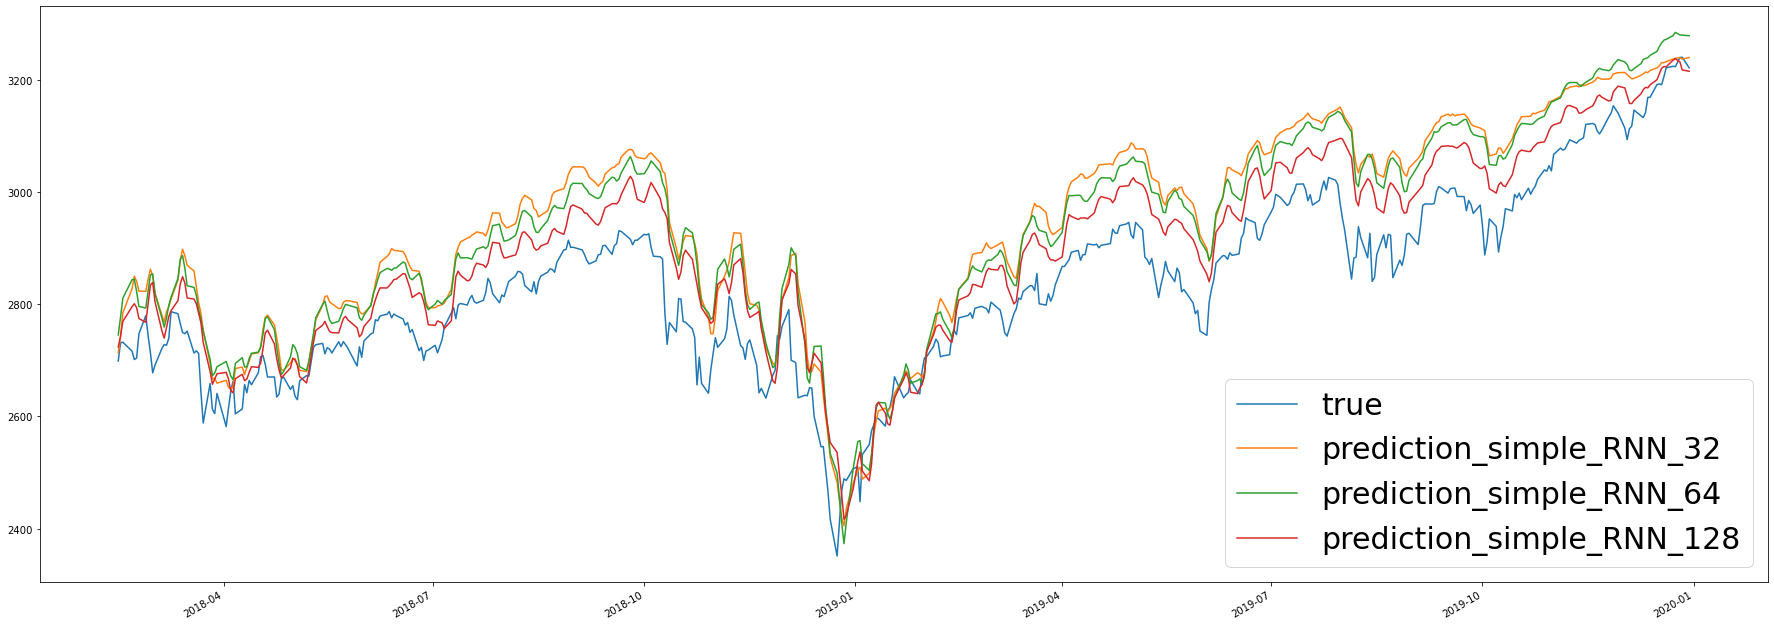

In [530]:
# # Creating Subplots

# fig = plt.figure(figsize=(24, 20))
# ax = fig.add_axes([0,0.5,1,0.4])

# ax.plot(val['Date'][30:,], vals_trans, label='true')
# # #ax.plot(val['Date'][30:,], preds_trans_sim, label='prediction_simple_RNN')
# ax.plot(val['Date'][30:,], preds_trans_sim32, label='prediction_simple_RNN_32')
# ax.plot(val['Date'][30:,], preds_trans_sim64, label='prediction_simple_RNN_64')
# ax.plot(val['Date'][30:,], preds_trans_sim128, label='prediction_simple_RNN_128')
# ax.legend(fontsize='30')


# # # Formatting Date#
# date_format = mpl_dates.DateFormatter('%Y-%m-%d')
# ax3.xaxis.set_major_formatter(date_format)
# fig.autofmt_xdate()
# fig.tight_layout()
# plt.show()

In [535]:
#val
predictions, values = opt1.evaluate(val_loader_one, batch_size=1, n_features=input_dim)
vals = np.concatenate(values, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()
vals_trans=vals*(val_max[3]-val_min[3])+val_min[3]
preds_trans_sim=preds*(val_max[3]-val_min[3])+val_min[3]

mse_sim=np.mean((vals_trans-preds_trans_sim)**2)

In [536]:
# test
predictions, values = opt1.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
vals = np.concatenate(values, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()

vals_trans_test=vals*(test_max[3]-test_min[3])+test_min[3]
preds_trans_sim_test=preds*(test_max[3]-test_min[3])+test_min[3]

mse_sim_test=np.mean((vals_trans_test-preds_trans_sim_test)**2)

# LSTM

In [24]:
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params).cuda()
print(model)

LSTMModel(
  (lstm): LSTM(15, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [25]:
g=make_dot(model(X_train),params=dict(list(model.named_parameters())))
g.view()
g.render("LSTM", format="png")


'LSTM.png'

[1/20] Training loss: 0.0177	 Validation loss: 0.1015
[2/20] Training loss: 0.0538	 Validation loss: 0.1598
[3/20] Training loss: 0.0307	 Validation loss: 0.0068
[4/20] Training loss: 0.0096	 Validation loss: 0.0048
[5/20] Training loss: 0.0046	 Validation loss: 0.0072
[6/20] Training loss: 0.0028	 Validation loss: 0.0087
[7/20] Training loss: 0.0030	 Validation loss: 0.0080
[8/20] Training loss: 0.0021	 Validation loss: 0.0045
[9/20] Training loss: 0.0011	 Validation loss: 0.0054
[10/20] Training loss: 0.0015	 Validation loss: 0.0040


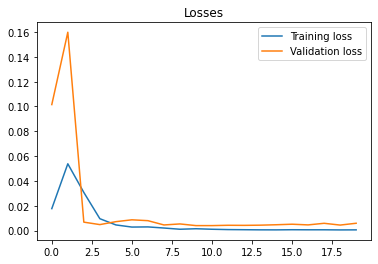

In [483]:
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt2 = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt2.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt2.plot_losses()

In [484]:
# VAL

predictions, values = opt2.evaluate(val_loader_one, batch_size=1, n_features=input_dim)
vals = np.concatenate(values, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()
vals_trans=vals*(val_max[3]-val_min[3])+val_min[3]
preds_trans_lstm=preds*(val_max[3]-val_min[3])+val_min[3]


mse_lstm=np.mean((vals_trans-preds_trans_lstm)**2)

In [485]:
# test
predictions, values = opt2.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
vals = np.concatenate(values, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()
vals_trans_test=vals*(test_max[3]-test_min[3])+test_min[3]
preds_trans_lstm_test=preds*(test_max[3]-test_min[3])+test_min[3]

mse_lstm_test=np.mean((vals_trans_test-preds_trans_lstm_test)**2)

# GRU

[1/20] Training loss: 0.0168	 Validation loss: 0.1196
[2/20] Training loss: 0.0366	 Validation loss: 0.0145
[3/20] Training loss: 0.0026	 Validation loss: 0.0078
[4/20] Training loss: 0.0034	 Validation loss: 0.0092
[5/20] Training loss: 0.0054	 Validation loss: 0.0115
[6/20] Training loss: 0.0065	 Validation loss: 0.0090
[7/20] Training loss: 0.0058	 Validation loss: 0.0069
[8/20] Training loss: 0.0042	 Validation loss: 0.0050
[9/20] Training loss: 0.0025	 Validation loss: 0.0038
[10/20] Training loss: 0.0015	 Validation loss: 0.0034


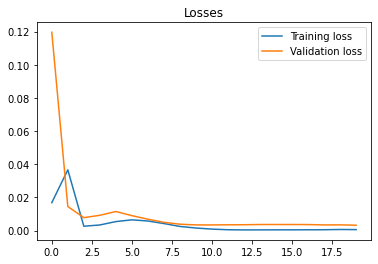

In [487]:
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('gru', model_params).cuda()

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt3 = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)

opt3.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)


opt3.plot_losses()

In [488]:
# val
predictions, values = opt3.evaluate(val_loader_one, batch_size=1, n_features=input_dim)
vals = np.concatenate(values, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()
vals_trans=vals*(val_max[3]-val_min[3])+val_min[3]
preds_trans_gru=preds*(val_max[3]-val_min[3])+val_min[3]

mse_gru=np.mean((vals_trans-preds_trans_gru)**2)

In [490]:
# test
predictions, values = opt3.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
vals = np.concatenate(values, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()
vals_trans_test=vals*(test_max[3]-test_min[3])+test_min[3]
preds_trans_gru_test=preds*(test_max[3]-test_min[3])+test_min[3]

mse_gru_test=np.mean((vals_trans_test-preds_trans_gru_test)**2)

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


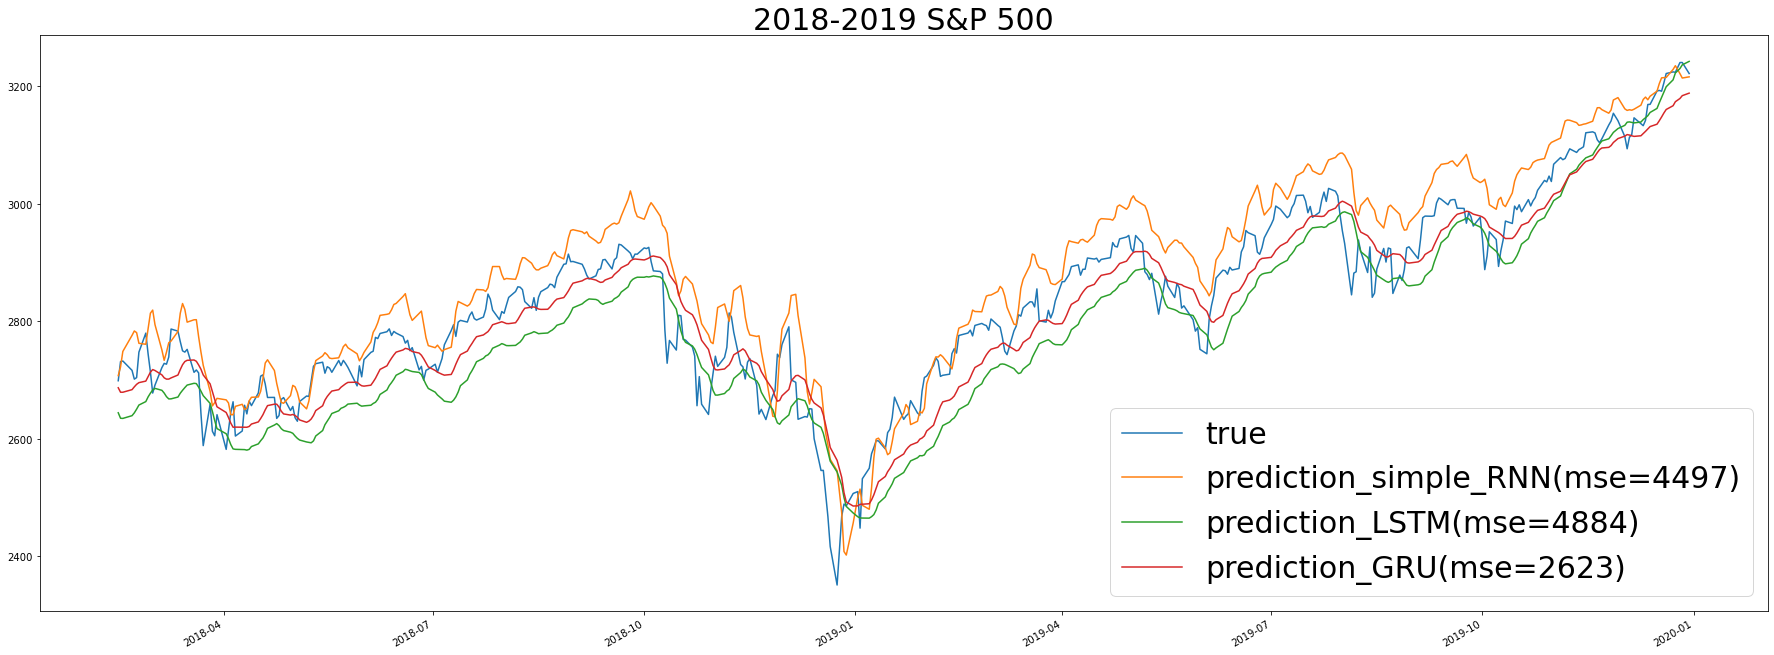

In [537]:
# Creating Subplots- val

fig = plt.figure(figsize=(24, 20))
ax = fig.add_axes([0,0.5,1,0.4])

ax.plot(val['Date'][30:,], vals_trans, label='true')
ax.plot(val['Date'][30:,], preds_trans_sim, label='prediction_simple_RNN'+ '(mse={})'.format(round(mse_sim)))
ax.plot(val['Date'][30:,], preds_trans_lstm, label='prediction_LSTM'+ '(mse={})'.format(round(mse_lstm)))
ax.plot(val['Date'][30:,], preds_trans_gru, label='prediction_GRU'+ '(mse={})'.format(round(mse_gru)))

#ax.plot(val['Date'][30:,], val['Close'][30:,], label='closed')
ax.legend(fontsize=30)
plt.title('2018-2019 S&P 500',fontsize=30)

# Formatting Date#
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
ax3.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


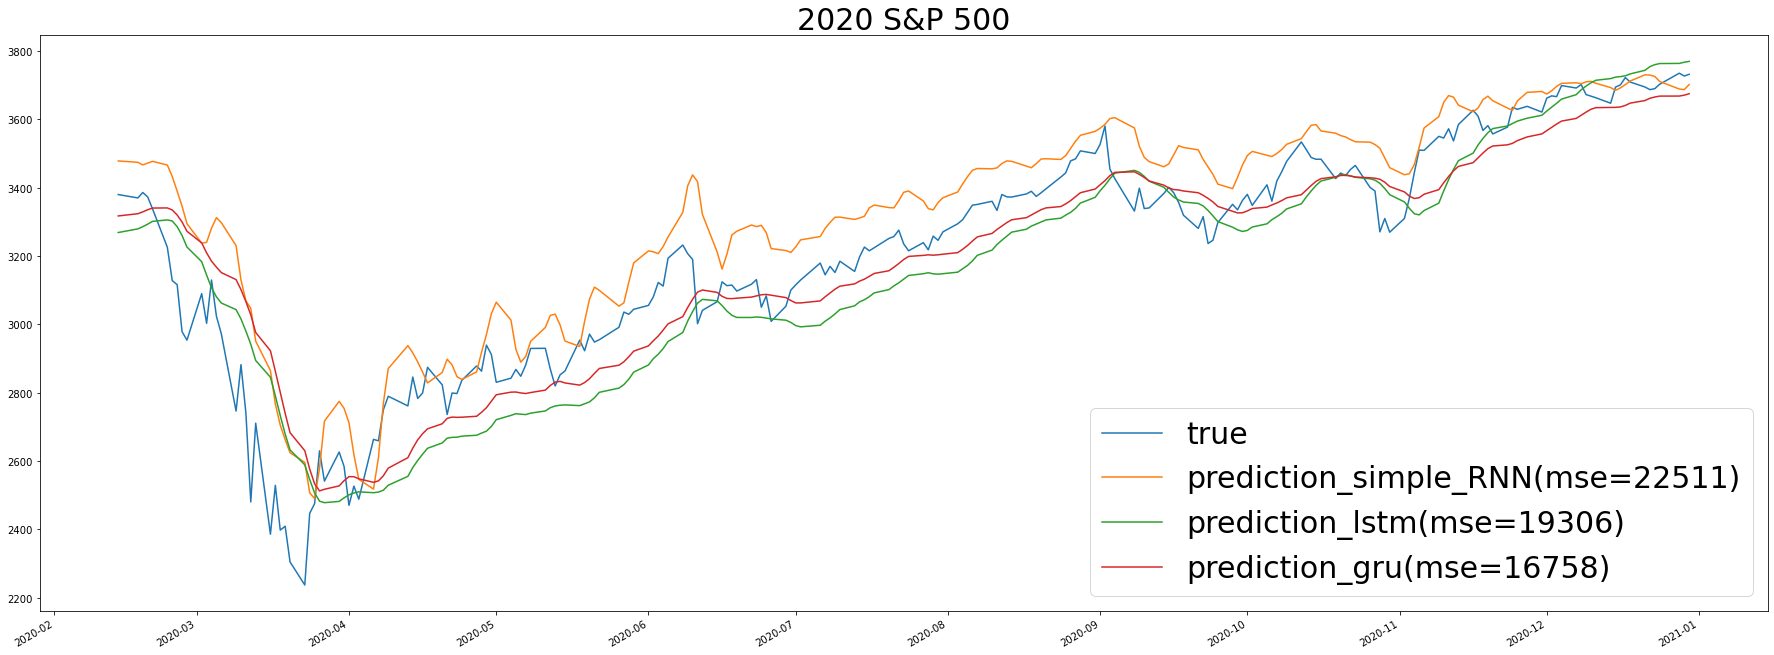

In [492]:
# Creating Subplots-test

fig = plt.figure(figsize=(24, 20))
ax = fig.add_axes([0,0.5,1,0.4])

ax.plot(test['Date'][30:,], vals_trans_test, label='true')
ax.plot(test['Date'][30:,], preds_trans_sim_test, label='prediction_simple_RNN'+ '(mse={})'.format(round(mse_sim_test)))
ax.plot(test['Date'][30:,], preds_trans_lstm_test, label='prediction_lstm'+ '(mse={})'.format(round(mse_lstm_test)))
ax.plot(test['Date'][30:,], preds_trans_gru_test, label='prediction_gru'+ '(mse={})'.format(round(mse_gru_test)))
ax.legend(fontsize='30')
plt.title('2020 S&P 500',fontsize=30)

# Formatting Date#
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
ax3.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()